Stack Overflow questions

# Environment

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup as bs
import re
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from imp import reload
from xgboost import XGBClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

# Data extraction

The StackExchange data explorer can be use to extract information from the SQL database:
https://data.stackexchange.com/stackoverflow/query/new \
Information about the database schema can be found at:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

* We will extract the *Id*, *Title*, *Body*, and *Tags* from the *Posts* table
* We are working on questions, therefore, *TypeId* must be 1,
* We will generate 5 tags for each question, we therefore select posts with at least 5 *tags*,
* In order to select qualitative enouth posts, we select posts with a minimum *score* of 5,
* We order the extraction by *CreationDate*.

We used SQL request to obtain the .csv file from the *Exchange data explorer*:\
SELECT TOP(50000) Id, Title, Body, Tags\
From Posts\
WHERE PostTypeId = 1\
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\
AND Score >= 5\
ORDER BY CreationDate

In [2]:
df = pd.read_csv('QueryResults.csv', index_col=0)
df.head()

,Title,Body,Tags
Id,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


# Data cleaning

* The database extraction contains html code, we remove it using the *BeautifulSoup* library:

* In order to keep the most relevant informationb from the cleaned text, we make the following hypothesis:
    * A question about programming is usually about how to program with something (a technology) to do something (a result), or how to optimize the code to do something,
    * Therefore, the verbs and nouns must encapsulate most of the relevant information,
    * In opposition to sentiment analysis, the adverbs are not that relevant.
* We filter the cleaned text in order to keep the verbs and nouns:

In [3]:
lemmatizer = WordNetLemmatizer()


def extract_body(text):

    # Remove the code citations, which is the text between the <code> tags
    no_code = re.sub('<code>[^>]+</code>', '', text)
    # Remove all the HTML tags
    text = bs(no_code).get_text()
    # Convert the text to lower
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text, language='english')
    # tokens = list(set(tokens).difference(set(stopwords.words('english')))) # we remove the stopwords
    # Remove the stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Generate the pos tags
    tags = nltk.pos_tag(tokens)
    # Select the target pos tags
    pos_filters = ['NN', 'NNP', 'NNS', 'NNPS', 'VB']
    tokens = [token for token, pos in tags if pos in pos_filters]
    # Lemmatize the result
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Format the result
    result = ','.join(tokens)

    return result

In [4]:
def extract_tags(text):

    # Remove the start and end '>' and '<'
    stripped = text.strip('<').strip('>')
    # Split the tags
    tokens = stripped.split('><')
    # tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result
    # Format the output
    result = ','.join(tokens)

    return result

In [5]:
def extract_title(text):

    # Convert the text to lower
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text, language='english')
    # tokens = list(set(tokens).difference(set(stopwords.words('english')))) # we remove the stopwords
    # Remove the stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Generate the pos tags
    tags = nltk.pos_tag(tokens)
    # Select the target pos tags
    pos_filters = ['NN', 'NNP', 'NNS', 'NNPS', 'VB']
    tokens = [token.replace('?', '') for token, pos in tags if pos in pos_filters]
    # Lemmatize the result
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Format the result
    result = ','.join(tokens)

    return result

* We apply the tranformers on the datasets columns:

In [6]:
df['Body_tokens'] = df['Body'].apply(extract_body)
df['Tags_tokens'] = df['Tags'].apply(extract_tags)
df['Title_tokens'] = df['Title'].apply(extract_title)
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens
Id,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"want,use,change,opacity,code,application,error...","c#,floating-point,type-conversion,double,decimal","convert,decimal,c"
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","c#,datetime,time,datediff,relative-time-span","calculate,time,c"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,pa...","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone"
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","performance,algorithm,language-agnostic,unix,pi","way,get,value,π"
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,z/os,get,time,error,something,fac...","c++,c,sockets,mainframe,zos","use,c,socket,api,c++,z/os"


# Join

In [7]:
df['Title_Body_tokens'] = df['Title_tokens'] + ',' + df['Body_tokens']
# df['Title_Body_tokens'] = df['Title_Body_tokens'].apply(lambda cell: ','.join(set(cell.split(','))))
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"want,use,change,opacity,code,application,error...","c#,floating-point,type-conversion,double,decimal","convert,decimal,c","convert,decimal,c,want,use,change,opacity,code..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","c#,datetime,time,datediff,relative-time-span","calculate,time,c","calculate,time,c,value,display,time,hour,day,m..."
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,pa...","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone","determine,user,timezone,way,web,server,determi..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","performance,algorithm,language-agnostic,unix,pi","way,get,value,π","way,get,value,π,way,obtain,value,π,challenge,w..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,z/os,get,time,error,something,fac...","c++,c,sockets,mainframe,zos","use,c,socket,api,c++,z/os","use,c,socket,api,c++,z/os,issue,socket,z/os,ge..."


# Exploration

In [11]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))

    return dist


body_frequencies = gen_frequencies(df['Body_tokens'])

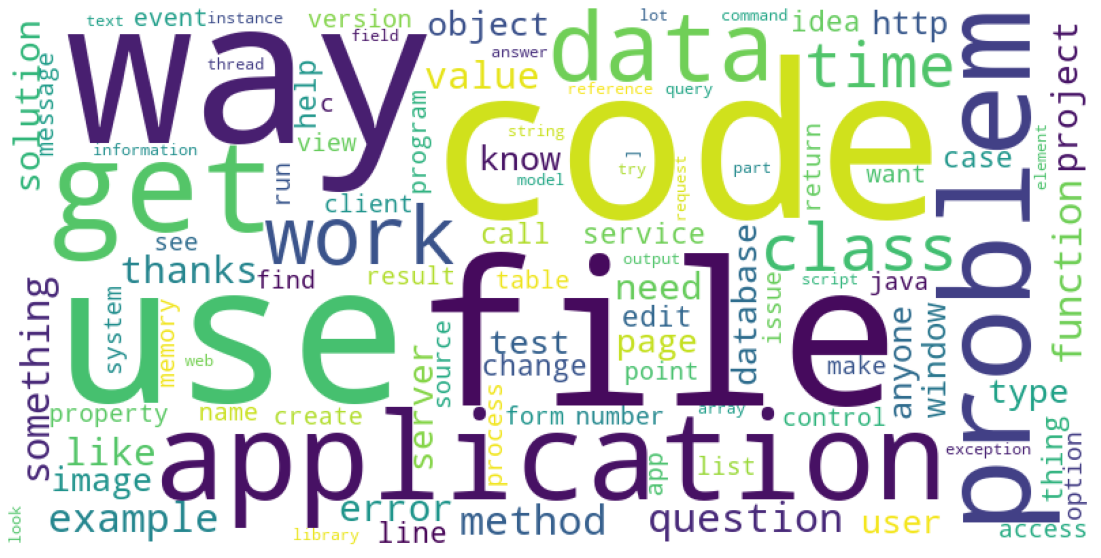

In [12]:
def word_cloud(frequencies):

    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        width=800,
        height=400
        ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


word_cloud(body_frequencies)

In [13]:
def plot_frequencies(frequencies, name, top=10):

    uniques = len(frequencies)
    dist_df = pd.DataFrame({
        'Tag':frequencies.keys(),
        'Frequency':frequencies.values()}
        ).sort_values('Frequency').tail(top)

    fig = px.bar(
        dist_df,
        x='Frequency',
        y='Tag',
        orientation='h',
        title=f'Top {top} {name} frequencies, unique values: {uniques}',
        height=750)
    fig.show()


plot_frequencies(body_frequencies, 'Body')

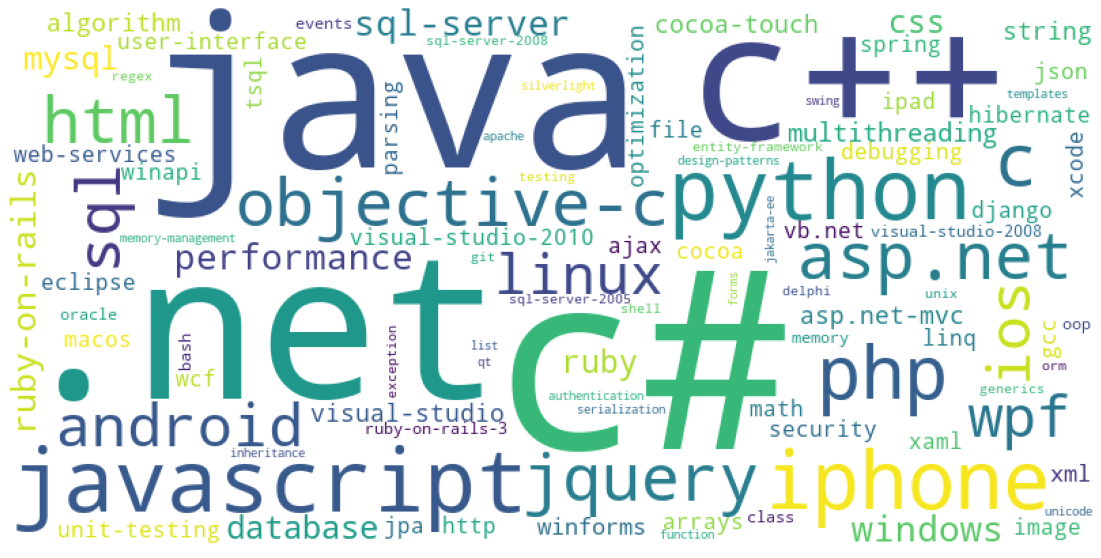

In [14]:
tags_frequencies = gen_frequencies(df['Tags_tokens'])
word_cloud(tags_frequencies)

In [15]:
plot_frequencies(tags_frequencies, 'Tags')

# LDA

* We create a dictionnary with the data and convert it to a bag of words corpus:

In [15]:
texts = df['Title_Body_tokens'].str.split(',')
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1000)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = [tfidf[text] for text in corpus]

* We test various N topics in order to calculate the coherence and perplexity scores:

In [16]:
topics_range = list(range(10, 200, 10))
coherence_scores = list()
perplexity_scores = list()
lda_models = list()

for n_topics in topics_range:

    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=10,
        workers=24)
    lda_models.append(lda_model)

    perplexity_scores.append(lda_model.log_perplexity(corpus))

    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts,
        dictionary=dictionary,
        coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=topics_range, y=coherence_scores, name='Coherence'),
    secondary_y=False)
fig.add_trace(
    go.Scatter(x=topics_range, y=perplexity_scores, name='Perplexity'),
    secondary_y=True)
fig.update_layout(title_text=f"Scores per n topics")
fig.update_xaxes(title_text='n topics')
fig.update_yaxes(title_text="Coherence score", secondary_y=False)
fig.update_yaxes(title_text="Perplexity score", secondary_y=True)
fig.update_layout(height=600)
fig.show()

* We train the Gensim model:

Saliency: a measure of how much the term tells you about the topic.
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
The size of the bubble measures the importance of the topics, relative to the data.
First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

In [17]:
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=9,
    random_state=42,
    passes=10,
    workers=24)

In [18]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Ca

When we have 5 or 10 topics, we can see certain topics are clustered together, this indicates the similarity between topics. What a a nice way to visualize what we have done thus far!

# Modelling

# Preprocessing

In [19]:
def gen_dataset(df, n_top=250, max_features=2500):

    X, y = df['Title_Body_tokens'], df['Tags_tokens']
    # Apply a train test split on the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # X processing
    # Keep the terms with the top frequencies
    tfid_vectorizer = TfidfVectorizer(max_features=max_features)
    # Fit and transform with the Tfid vectorizer on X train
    X_train = tfid_vectorizer.fit_transform(X_train)
    # Transform X test
    X_test = tfid_vectorizer.transform(X_test)
    
    # y processing
    # Calculate the tags frequencies
    y_frequencies = gen_frequencies(y_train)
    # Extract the top tags
    y_top_tags = extract_top(y_frequencies, n_top)

    # Keep only the top tags from the target
    y_train = keep_top(y_train, y_top_tags)
    multi_label_binarizer = MultiLabelBinarizer(classes=y_top_tags)
    # Binarize the target
    y_train = multi_label_binarizer.fit_transform(y_train)

    y_test = keep_top(y_test, y_top_tags)
    y_test = multi_label_binarizer.transform(y_test)
    
    print(f'Train size: {X_train.shape[0]}')
    print(f'Test size: {X_test.shape[0]}')

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_dataset(df, 1000, 5000)

NameError: name 'extract_top' is not defined

In [ ]:
TOP = 250
top_tags_df = pd.DataFrame(
    {'Tag':tags_frequencies.keys(), 'Frequency':tags_frequencies.values()}
    ).sort_values('Frequency', ascending=False).head(TOP)
top_tags = top_tags_df['Tag'].values
top_tags_df.head()

,Tag,Frequency
0,c#,9039
46,java,6156
42,.net,5868
19,c++,4356
200,javascript,3311


In [ ]:
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"application,code,build,project,work,change,opa...","c#,floating-point,type-conversion,double,decimal","convert,decimal,c","convert,code,decimal,build,project,application..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,hour,time,day,month","c#,datetime,time,datediff,relative-time-span","time,c,calculate","value,time,c,day,month,calculate,hour"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"page,determine,part,timezone,user,header,way,h...","html,browser,timezone,user-agent,timezone-offset","timezone,user,determine","page,determine,part,timezone,user,header,way,h..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"x86,built-ins,stuff,challenge,order,compare,co...","performance,algorithm,language-agnostic,unix,pi","value,way,get","x86,flag,built-ins,stuff,challenge,order,compa..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"check,matter,programmer,socket,something,issue...","c++,c,socket,mainframe,zos","socket,z/os,c,api,c++,use","socket,check,problem,file,idea,use,output,prog..."


In [ ]:
df[df['Target'].str.len()==0].shape[0]

KeyError: 'Target'

In [ ]:
df = df[df['Target'].str.len()!=0]
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,Target
Id,,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"code,vb.net,use,opacity,application,want,work,...","c#,floating-point,type-conversion,double,decimal","convert,c,decimal","vb.net,application,want,work,build,change,proj...","floating-point,c#"
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"hour,month,time,value,display,day","c#,datetime,time,datediff,relative-time-span","time,c,calculate","time,month,value,display,day,hour,c,calculate","datetime,time,c#"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"standard,page,part,way,header,web,server,deter...","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone","standard,page,part,way,header,web,server,user,...","browser,html"
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"configuration,option,test,obtain,system,theory...","performance,algorithm,language-agnostic,unix,pi","value,way,get,π","option,obtain,test,theory,flag,inline,way,opti...","algorithm,language-agnostic,unix,performance"
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"type,socket,work,matter,sys/sockets.h,hitting,...","c++,c,socket,mainframe,zos","socket,use,c,api,c++","type,check,test,problem,definition,statement,z...","c,c++,socket"


In [ ]:
tfid_vectorizer = TfidfVectorizer(max_features=1000)
X = tfid_vectorizer.fit_transform(df['Title_Body_tokens'])
topics = tfid_vectorizer.get_feature_names_out().tolist()
df_X = pd.DataFrame(
    data=X.toarray(),
    index=df.index,
    columns=topics)
df_X.head()

,_mysql,ability,abstract,access,account,achieve,act,action,activity,add,...,x86,xaml,xcode,xml,xp,year,yes,yield,zero,zip
Id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
multi_label_binarizer = MultiLabelBinarizer()
y = multi_label_binarizer.fit_transform(df['Target'].str.split(','))
tags = multi_label_binarizer.classes_
df_y = pd.DataFrame(
    data=y,
    index=df.index,
    columns=tags)
df_y.head()

,.net,.net-3.5,.net-4.0,64-bit,ado.net,ajax,algorithm,android,animation,apache,...,web-services,winapi,window,windows-7,winforms,wpf,x86,xaml,xcode,xml
Id,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing function

In [16]:
def extract_top(frequencies:dict, n_top:int):

    top_values = pd.DataFrame(
        {'Tag':frequencies.keys(), 'Frequency':frequencies.values()}
        ).sort_values('Frequency', ascending=False).head(n_top)['Tag'].values
    
    return top_values

In [17]:
def keep_top(series:pd.Series, top_values:list):
    
    series = series.apply(lambda cell: list(set(cell.split(',')).intersection(top_values)))

    return series

In [18]:
class DatasetTransformer():

    def __init__(self, df:pd.DataFrame, X:str, y:str):

        self.dataset = df
        self.X = df[X]
        self.y = df[y]
        self.y_df = None
        self.multi_label_binarizer = None
        self.tfid_vectorizer = None
    
    def gen_train_test(self, n_top=250, max_features=2500):
        
        # Apply a train test split on the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            self.y,
            test_size=0.2,
            random_state=42)
        
        # y processing
        # Calculate the tags frequencies
        y_frequencies = gen_frequencies(y_train)
        # Extract the top tags
        y_top_tags = extract_top(y_frequencies, n_top)
        # Keep only the top tags from the target
        y_train = keep_top(y_train,y_top_tags)
        y_test = keep_top(y_test,y_top_tags)

        # Drop the empty rows we might have generated
        train_drop = y_train[y_train.map(len)==0].keys()
        test_drop = y_test[y_test.map(len)==0].keys()
        y_train.drop(train_drop,inplace=True)
        y_test.drop(test_drop,inplace=True)
        print(f'Dropped Train samples: {train_drop.shape[0]}')
        print(f'Dropped Test samples: {test_drop.shape[0]}')

        # Binarize the target
        self.multi_label_binarizer = MultiLabelBinarizer(classes=y_top_tags)
        y_train_matrix = self.multi_label_binarizer.fit_transform(y_train)
        y_test_matrix = self.multi_label_binarizer.transform(y_test)
        
        # Convert the matrixes back to pandas DataFrames
        tags = self.multi_label_binarizer.classes_
        y_train = pd.DataFrame(
            data=y_train_matrix,
            index=y_train.index,
            columns=tags)
        y_test = pd.DataFrame(
            data=y_test_matrix,
            index=y_test.index,
            columns=tags)

        # Extract the y data to join predictions later
        self.y_df = self.dataset.loc[y_test.index, :]

        # X processing
        X_train.drop(train_drop, inplace=True)
        X_test.drop(test_drop, inplace=True)

        # Keep the terms with the top frequencies using the max_features arg
        self.tfid_vectorizer = TfidfVectorizer(max_features=max_features)
        # Fit and transform with the Tfid vectorizer on X train
        X_train_matrix = self.tfid_vectorizer.fit_transform(X_train)
        # Transform X test
        X_test_matrix = self.tfid_vectorizer.transform(X_test)

        # Convert the matrixes back to pandas DataFrames
        topics = self.tfid_vectorizer.get_feature_names_out().tolist()
        X_train = pd.DataFrame(
            data=X_train_matrix.toarray(),
            index=X_train.index,
            columns=topics)
        X_test = pd.DataFrame(
            data=X_test_matrix.toarray(),
            index=X_test.index,
            columns=topics)

        print(f'Train size: {X_train.shape[0]}')
        print(f'Test size: {X_test.shape[0]}')

        return X_train, X_test, y_train, y_test

    def join_predictions(self, name:str, predictions:np.array):

        # Use the binarizer to inverse transform the prediction array
        predictions = self.multi_label_binarizer.inverse_transform(predictions)
        # Add the predictions to the dataset
        self.y_df[name] = predictions
        
        return self.y_df
    
    def get_predictions(self):

        return self.y_df


transformer = DatasetTransformer(df, 'Title_Body_tokens', 'Tags_tokens')
X_train, X_test, y_train, y_test = transformer.gen_train_test(n_top=1000, max_features=1000)

Dropped Train samples: 66
Dropped Test samples: 26
Train size: 39934
Test size: 9974


In [19]:
X_train.to_csv('./X_train.csv')
X_test.to_csv('./X_test.csv')
y_train.to_csv('./y_train.csv')
y_test.to_csv('./y_test.csv')

In [ ]:
X_train.head()

,ability,access,accomplish,account,achieve,action,activity,add,addition,address,...,wsdl,www,x86,xaml,xcode,xml,xp,year,zip,zoom
Id,,,,,,,,,,,,,,,,,,,,,
5427681,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4291253,0.0,0.20901,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6286656,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276370,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1911856,0.0,0.00000,0.0,0.0,0.0,0.091521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head()

,c#,java,.net,c++,javascript,python,iphone,php,c,objective-c,...,client-server,rhino-mocks,geospatial,string-formatting,bundle,blob,screenshot,limit,soa,blocking
Id,,,,,,,,,,,,,,,,,,,,,
5427681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4291253,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6286656,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1911856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Evaluation function

In [20]:
class PerformanceReport():

    def __init__(self):

        # Initialize our report DataFrame
        self.report = pd.DataFrame(columns=[
            'Accuracy',
            'Precision_macro',
            'Precision_micro',
            'Recall_macro',
            'Recall_micro',
            'F1_macro',
            'F1_micro'])

    def evaluate(self, name:str ,y_true:np.array ,y_pred:np.array):
        
        # Calculate the scores
        accuracy = accuracy_score(y_true, y_pred)
        precision_macro = precision_score(y_true, y_pred, average='macro')
        precision_micro = precision_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_micro = recall_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')

        # Append the scores to our report
        self.report.loc[name,:] = [
            accuracy,
            precision_macro,
            precision_micro,
            recall_macro,
            recall_micro,
            f1_macro,
            f1_micro]
            
        print(self.report.loc[name,:])
    
    def get(self):

        return self.report


report = PerformanceReport()

# KNN

In [34]:
model = KNeighborsClassifier()
model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)

In [35]:
dump(model, './app/model.joblib')

['./app/model.joblib']

In [36]:
report.evaluate('KNN', y_test.values,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.004813
Precision_macro    0.269555
Precision_micro    0.556223
Recall_macro       0.067586
Recall_micro       0.109774
F1_macro           0.098392
F1_micro            0.18336
Name: KNN, dtype: object


In [32]:
model.predict_proba(X_test)

[array([[0.8, 0.2],
        [0.8, 0.2],
        [1. , 0. ],
        ...,
        [1. , 0. ],
        [0.6, 0.4],
        [0.6, 0.4]]),
 array([[1. , 0. ],
        [1. , 0. ],
        [0.8, 0.2],
        ...,
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ]]),
 array([[0.8, 0.2],
        [1. , 0. ],
        [1. , 0. ],
        ...,
        [1. , 0. ],
        [0.8, 0.2],
        [0.8, 0.2]]),
 array([[1. , 0. ],
        [0.6, 0.4],
        [1. , 0. ],
        ...,
        [0.2, 0.8],
        [0.6, 0.4],
        [0.6, 0.4]]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 array([[0.8, 0.2],
        [1. , 0. ],
        [0.8, 0.2],
        ...,
        [1. , 0. ],
        [0.8, 0.2],
        [0.8, 0.2]]),
 array([[0.8, 0.2],
        [0.6, 0.4],
        [1. , 0. ],
        ...,
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ]]),
 array([[1. , 0. ],
        [1. , 0. ],
        [0.8, 0.2],
       

In [29]:
model

OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [29]:
report.get()

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
KNN,0.004813,0.269555,0.556223,0.067586,0.109774,0.098392,0.18336


In [37]:
transformer.join_predictions('KNN', preds)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN
Id,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",()
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",()
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(eclipse,)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",()
...,...,...,...,...,...,...,...,...
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(class,)"
3455056,Lightweight command-line image resizer?,<p>I'm looking for an image resizer / thumbnai...,<imagemagick><thumbnails><utility><freeimage><...,"image,resizer,/,thumbnailer,efficient,somethin...","imagemagick,thumbnails,utility,freeimage,graph...","image,resizer","image,resizer,image,resizer,/,thumbnailer,effi...",()
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++, c, macros)"


# SVM

In [27]:
model = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [32]:
report.evaluate('SVM', y_test, preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.018849
Precision_macro     0.31562
Precision_micro    0.715956
Recall_macro       0.116324
Recall_micro       0.260537
F1_macro           0.156532
F1_micro           0.382047
Name: SVM, dtype: object


In [33]:
report.get()

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
KNN,0.004813,0.269555,0.556223,0.067586,0.109774,0.098392,0.18336
SVM,0.018849,0.31562,0.715956,0.116324,0.260537,0.156532,0.382047


In [34]:
transformer.join_predictions('SVM', preds)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM
Id,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(eclipse,)","(eclipse,)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),()
...,...,...,...,...,...,...,...,...,...
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(class,)",()
3455056,Lightweight command-line image resizer?,<p>I'm looking for an image resizer / thumbnai...,<imagemagick><thumbnails><utility><freeimage><...,"image,resizer,/,thumbnailer,efficient,somethin...","imagemagick,thumbnails,utility,freeimage,graph...","image,resizer","image,resizer,image,resizer,/,thumbnailer,effi...",(),"(image,)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++, c, macros)","(c, linux, macos, macros)"


# SGD

In [35]:
from sklearn.linear_model import SGDClassifier

In [36]:
model = OneVsRestClassifier(SGDClassifier(), n_jobs=-1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [37]:
report.evaluate('SGD', y_test,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.013836
Precision_macro    0.117511
Precision_micro    0.817038
Recall_macro       0.046555
Recall_micro       0.174867
F1_macro           0.062104
F1_micro           0.288078
Name: SGD, dtype: object


In [38]:
report.get()

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
KNN,0.004813,0.269555,0.556223,0.067586,0.109774,0.098392,0.18336
SVM,0.018849,0.31562,0.715956,0.116324,0.260537,0.156532,0.382047
SGD,0.013836,0.117511,0.817038,0.046555,0.174867,0.062104,0.288078


In [39]:
transformer.join_predictions('SGD', preds)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD
Id,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)",()
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",()
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(eclipse,)","(eclipse,)","(eclipse,)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),(),()
...,...,...,...,...,...,...,...,...,...,...
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(class,)",(),()
3455056,Lightweight command-line image resizer?,<p>I'm looking for an image resizer / thumbnai...,<imagemagick><thumbnails><utility><freeimage><...,"image,resizer,/,thumbnailer,efficient,somethin...","imagemagick,thumbnails,utility,freeimage,graph...","image,resizer","image,resizer,image,resizer,/,thumbnailer,effi...",(),"(image,)",()
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++, c, macros)","(c, linux, macos, macros)","(linux, macos)"


# Random Forest

In [ ]:
stop

In [21]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

In [22]:
def set_threshold(preds_proba, threshold):

    result = np.where(
        np.array(
            [pred[:,1] for pred in preds_proba]
            ).transpose() >= threshold, 1, 0)

    return result


preds_threshold = set_threshold(preds_proba, 0.25)

In [ ]:
def get_firsts(preds_proba, n_first):

    result = np.array([
        np.where(pred >= np.partition(pred, -n_first)[-n_first], 1, 0) 
        for pred in np.array([pred[:,1] for pred in preds_proba
        ]).transpose()])

    return result


preds_firsts = get_firsts(preds_proba, 5)

NameError: name 'preds_proba' is not defined

In [ ]:
report.evaluate('Random Forest', y_test,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.029237
Precision_macro    0.212511
Precision_micro    0.810272
Recall_macro       0.044826
Recall_micro       0.178239
F1_macro           0.065837
F1_micro           0.292201
Name: Random Forest, dtype: object


In [ ]:
transformer.join_predictions('RandomForest', preds_threshold)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD,RandomForest
Id,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),(),"(c#, windows)"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)","(c#,)","(c#, .net, wpf, winforms)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",(),"(sql, database, postgresql)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(c++, visual-c++)","(eclipse,)","(eclipse,)","(java, linux, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),"(c#,)",(),"(c#, string)"
...,...,...,...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"edit,someone,point,distance,point,one,pac,man,...","algorithm,language-agnostic,math,geometry,topo...","center,mass,point,map,distance,point","center,mass,point,map,distance,point,edit,some...","(algorithm, math)","(algorithm,)",(),"(algorithm,)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(c++,)","(c#,)",(),"(c#,)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++,)","(c, macos)","(linux, macos)","(c, linux, macos)"


In [ ]:
report.evaluate('Random Forest 0.25', y_test, preds_threshold)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.045065
Precision_macro    0.415564
Precision_micro    0.600702
Recall_macro       0.156227
Recall_micro       0.383461
F1_macro           0.197109
F1_micro           0.468105
Name: Random Forest 0.25, dtype: object


In [ ]:
transformer.join_predictions('RandomForest 0.25', preds_threshold)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD,RandomForest,RandomForest 0.25
Id,,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),(),"(c#, windows)","(c#, windows)"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)","(c#,)","(c#, .net, wpf, winforms)","(c#, .net, wpf, winforms)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",(),"(sql, database, postgresql)","(sql, database, postgresql)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(c++, visual-c++)","(eclipse,)","(eclipse,)","(java, linux, eclipse)","(java, linux, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),"(c#,)",(),"(c#, string)","(c#, string)"
...,...,...,...,...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"edit,someone,point,distance,point,one,pac,man,...","algorithm,language-agnostic,math,geometry,topo...","center,mass,point,map,distance,point","center,mass,point,map,distance,point,edit,some...","(algorithm, math)","(algorithm,)",(),"(algorithm,)","(algorithm,)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(c++,)","(c#,)",(),"(c#,)","(c#,)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++,)","(c, macos)","(linux, macos)","(c, linux, macos)","(c, linux, macos)"


In [ ]:
report.evaluate('Random Forest n5', y_test, preds_firsts)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.003327
Precision_macro    0.345121
Precision_micro    0.353751
Recall_macro       0.346375
Recall_micro       0.579845
F1_macro            0.31545
F1_micro           0.439421
Name: Random Forest n5, dtype: object


In [ ]:
transformer.join_predictions('RandomForest n5', preds_firsts)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD,RandomForest,RandomForest 0.25,RandomForest n5
Id,,,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),(),"(c#, windows)","(c#, windows)","(c#, .net, windows, winapi, unicode)"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)","(c#,)","(c#, .net, wpf, winforms)","(c#, .net, wpf, winforms)","(c#, .net, wpf, winforms, xaml)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",(),"(sql, database, postgresql)","(sql, database, postgresql)","(java, sql, mysql, database, postgresql)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(c++, visual-c++)","(eclipse,)","(eclipse,)","(java, linux, eclipse)","(java, linux, eclipse)","(java, c++, c, linux, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),"(c#,)",(),"(c#, string)","(c#, string)","(c#, java, .net, c++, c, string)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"edit,someone,point,distance,point,one,pac,man,...","algorithm,language-agnostic,math,geometry,topo...","center,mass,point,map,distance,point","center,mass,point,map,distance,point,edit,some...","(algorithm, math)","(algorithm,)",(),"(algorithm,)","(algorithm,)","(c++, algorithm, math, graphics, graph)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(c++,)","(c#,)",(),"(c#,)","(c#,)","(c#, .net, c++, wpf, class, mvvm)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++,)","(c, macos)","(linux, macos)","(c, linux, macos)","(c, linux, macos)","(c++, python, c, linux, macos, g++)"


In [ ]:
report.get()

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
KNN,0.013913,0.490043,0.538479,0.114863,0.145249,0.173132,0.228786
SVM,0.055449,0.5882,0.719664,0.259575,0.344434,0.340051,0.465891
SGD,0.034479,0.3534,0.825858,0.122804,0.219477,0.167952,0.346791
Random Forest,0.029237,0.212511,0.810272,0.044826,0.178239,0.065837,0.292201
Random Forest 0.25,0.045065,0.415564,0.600702,0.156227,0.383461,0.197109,0.468105
Random Forest n5,0.003327,0.345121,0.353751,0.346375,0.579845,0.31545,0.439421


# Saving files

*For further use*

In [23]:
from joblib import dump

In [24]:
dump(transformer.multi_label_binarizer, './app/multi_label_binarizer.joblib')
dump(transformer.tfid_vectorizer, './app/tfid_vectorizer.joblib')
dump(model, './app/model.joblib')

['./app/model.joblib']

In [ ]:
stop

NameError: name 'stop' is not defined

# Gradient Boosting

In [ ]:
model = OneVsRestClassifier(XGBClassifier(use_label_encoder=False),n_jobs=-1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

[01:14:43] WARNING: /private/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/pip-install-0v9f4ihp/xgboost_94d80266f0644a9c9ea06cf57bd1d023/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:44] WARNING: /private/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/pip-install-0v9f4ihp/xgboost_94d80266f0644a9c9ea06cf57bd1d023/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:44] WARNING: /private/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/pip-install-0v9f4ihp/xgboost_94d80266f0644a9c9ea06cf57bd1d023/build/temp.macosx-11.0-arm64-3.9/xgboost/sr

KeyboardInterrupt: 

In [ ]:
report.evaluate('XGboost',y_test,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.042545
Precision_macro    0.512767
Precision_micro     0.69203
Recall_macro       0.218968
Recall_micro       0.321299
F1_macro           0.287854
F1_micro           0.438848
Name: SVM, dtype: object


In [ ]:
report.get()

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
Random Forest,0.024398,0.211125,0.796779,0.042267,0.165896,0.062738,0.274615
Random Forest 0.25,0.04073,0.384474,0.597654,0.138707,0.358986,0.176084,0.448547
SVM,0.042545,0.512767,0.69203,0.218968,0.321299,0.287854,0.438848


In [ ]:
transformer.join_predictions('XGBoost',preds)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM
Id,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"hell,duplicate,lot,get,begin,wonder,window,tim...","c#,limit,filepath,maxlength,max-path","get,limit,path,way,c","window,issue,get,hell,limit,begin,wonder,figur...",()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"winforms,idea,ta,fore,complains,thing,re-input...","c#,winforms,richtextbox,rtf,richtext","rtf,reset,richtextbox","winforms,box,idea,ta,fore,example,code,anyone,...","(c#, winforms)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"amount,instance,operation,timestamp,number,app...","database,postgresql,database-design,crud,audit...","history,application,audit,strategy,db,trail/ch...","amount,instance,operation,timestamp,number,suc...","(database,)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,source,project1,eclipse,idea,proje...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",rename,"googled-out,idea,error,source,folder,project1,...","(java, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"post,code,comment,solution,difference,c,c++,co...","c++,c,string,char,string-comparison",":compare,string","post,code,operator,solution,comment,difference...",()
...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"pick,explain,definition,explanation,test,case,...","algorithm,language-agnostic,math,geometry,topo...","mass,distance,point,map,center,minimizes","distance,situation,point,someone,top,example,m...","(algorithm,)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"extends,apart,thats,foundation,intermediate,li...","c#,wpf,mvvm,dependency-properties,mvvm-foundation","class,extending,c","mvvm,class,extra,like,viewmodels,thats,foundat...","(mvvm,)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"osx,linux,macro,differentiate,mac","linux,macos,gcc,cross-platform,macro","osx,linux,macro,differentiate,mac","osx,macro,linux,differentiate,mac","(c, macos)"


# Results Visualization